In [108]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import mmcv
import cv2
from collections import Counter
import numpy as np
import lap

In [5]:
players = pd.read_csv('./demos/custom_5vals_colors_all_30ep_debug/2021_01_20_Colorado_at_Washington_orig.csv')

In [135]:
players1 = set(players.loc[players['market'] == 'Colorado']['jersey_number'].tolist())
players2 = set(players.loc[players['market'] == 'Washington']['jersey_number'].tolist())

### Read jersey tracking info

In [145]:
tracking = json.load(open('./demos/custom_5vals_colors_all_30ep_debug/2021_01_20_Colorado_at_Washington_orig.json'))
len(tracking)

137540

In [146]:
team_1 = []
team_2 = []
for k, v in tracking.items():
    for el in v:
        curr_el = el.split(',')
        if curr_el[-2] == '0.0':
            team_1.append(curr_el[-1])
        elif curr_el[-2] == '1.0':
            team_2.append(curr_el[-1])
        
cnt_1 = Counter(team_1)
cnt_2 = Counter(team_2)

In [147]:
cnt_1

Counter({'41': 39808,
         '21': 45567,
         '5': 56067,
         'None': 24326,
         '25': 47915,
         '24': 44382,
         '11': 24960,
         '10': 3537,
         '4': 679,
         '55': 2132,
         '14': 1,
         '2': 1458,
         '12': 19153,
         '3': 46215,
         '13': 24049,
         '1': 2464,
         '53': 3000,
         '33': 1174,
         '30': 2,
         '0': 2437,
         '20': 633,
         '32': 7,
         '50': 329})

#### Remove non-existing jersey numbers


In [138]:
def remove_nonex(cnt, players1, players2):
    
    for k in list(cnt):
        if k=='None': 
            cnt.pop(k, 'None')
        elif int(k) not in players1 and int(k) not in players2:
            cnt.pop(k, 'None')

    return cnt

cnt_1 = remove_nonex(cnt_1, players1, players2)
cnt_2 = remove_nonex(cnt_2, players1, players2)

56067


In [103]:
def calc_hist_loss(cnt, players1, players2):
    
    max_ = max(list(cnt.values()))
    min_ = min(list(cnt.values()))
    loss_1 = 0
    loss_2 = 0
    for k, v in cnt.items():

        curr_val = (int(v) - min_)/(max_ - min_) 
        
        if int(k) in players1 and int(k) in players2:
            loss_1 += 1 - curr_val
            loss_2 += 1 - curr_val           
        elif int(k) in players1 and int(k) not in players2:
            loss_1 += 1 - curr_val
            loss_2 += 1
        elif int(k) not in players1 and int(k) in players2:
            loss_1 += 1
            loss_2 += 1 - curr_val
        elif int(k) not in players1 and int(k) not in players2:
            loss_1 += 1
            loss_2 += 1
            
    return loss_1, loss_2

In [104]:
cnt1_l1, cnt1_l2 = calc_hist_loss(cnt_1, players1, players2)
cnt2_l1, cnt2_l2 = calc_hist_loss(cnt_2, players1, players2)

In [105]:
cnt1_l1, cnt1_l2, cnt2_l1, cnt2_l2

(6.901399833132474, 11.555780105682764, 13.25510101010101, 11.021439393939394)

In [122]:
cost_matrix = np.array([[cnt1_l1, cnt1_l2], [cnt2_l1, cnt2_l2]])
print(cost_matrix)
matches, unmatched_a, unmatched_b = [], [], []
cost, x, y = lap.lapjv(cost_matrix, extend_cost=True)
for ix, mx in enumerate(x):
    if mx >= 0:
        matches.append([ix, mx])
unmatched_a = np.where(x < 0)[0]
unmatched_b = np.where(y < 0)[0]
matches = np.asarray(matches)

[[ 6.90139983 11.55578011]
 [13.25510101 11.02143939]]


In [123]:
matches

array([[0, 0],
       [1, 1]])

### Calculate stats for each player

In [144]:
def get_stats(cnt, players, length=len(tracking)):
    
    res = {}
    for k, v in cnt.items():
        if int(k) in players:
            res[k] = round(100*(v / length), 2)
            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

print(get_stats(cnt_1, players1))
print(get_stats(cnt_2, players2))

{'5': 40.76, '25': 34.84, '3': 33.6, '21': 33.13, '24': 32.27, '41': 28.94, '11': 18.15, '13': 17.49, '12': 13.93}
{'5': 57.91, '0': 40.3, '55': 40.09, '1': 31.81, '10': 30.94, '13': 27.36, '22': 2.99, '00': 0.33}


In [30]:
video = mmcv.VideoReader('./demos/custom_5vals_colors_all_30ep_debug/2021_01_20_Colorado_at_Washington_orig.mp4')

In [124]:
video

In [131]:
frame = video.get_frame(100000)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

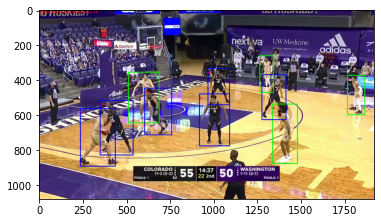

In [132]:
plt.imshow(frame)

colorado - black forma
washington - white form



GROUND TRUTH:
blue  - colorado - 0.0
green - washington - 1.0

PREDICTION:
0.0 - COLORADO
1.0 - WASHINGTON

RESULT:
    TRUE!